# Определение возраста покупателей

## Описание исследования

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Для этого супермаркету необходима модель для автоматического определения приблизительного возраста покупателя.

## Цель исследования

Целью исследования является разработка модели, которая по фотографии сможет определить приблизительный возраст человека. Качество модели определяется метрикой MAE, значение которой на тестовой выборке не должно быть выше 8.0.

## Задачи исследования

- Загрузка и первичное знакомство с данными;
- Исследовательский анализ набора фотографий;
- Подготовка данных к обучению;
- Решение задачи регрессии - обучение с учителем нейронной сети `ResNet50` и проверка её качества по метрике MAE на тестовой выборке.

## Исходные данные

Для исследования используется набор фотографий людей с указанием возраста с сайта ChaLearn Looking at People.

Папка со всеми изображениями: `/final_files`.

CSV-файл `labels.csv` с двумя колонками:
- `file_name` - название файла с изображением;
- `real_age` - возраст человека (целевой признак).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-исследования" data-toc-modified-id="Описание-исследования-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание исследования</a></span></li><li><span><a href="#Цель-исследования" data-toc-modified-id="Цель-исследования-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Цель исследования</a></span></li><li><span><a href="#Задачи-исследования" data-toc-modified-id="Задачи-исследования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Задачи исследования</a></span></li><li><span><a href="#Исходные-данные" data-toc-modified-id="Исходные-данные-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исходные данные</a></span></li><li><span><a href="#Импорт-библиотек-и-знакомство-с-данными" data-toc-modified-id="Импорт-библиотек-и-знакомство-с-данными-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Импорт библиотек и знакомство с данными</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Задача-регрессии.-Обучение-с-учителем-нейронной-сети-ResNet50" data-toc-modified-id="Задача-регрессии.-Обучение-с-учителем-нейронной-сети-ResNet50-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Задача регрессии. Обучение с учителем нейронной сети ResNet50</a></span></li><li><span><a href="#Выводы-по-результатам-обучения-модели" data-toc-modified-id="Выводы-по-результатам-обучения-модели-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Выводы по результатам обучения модели</a></span></li></ul></div>

## Импорт библиотек и знакомство с данными

In [1]:
# делаем необходимые импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# объявляем константы
RANDOM_STATE = 2024

In [3]:
# загружаем данные
try:
    labels = pd.read_csv(
        '/datasets/faces/labels.csv'
    )
except:
    labels = pd.read_csv(
        'https://code.s3.yandex.net/datasets/faces/labels.csv'
    )

In [4]:
# создаем функцию для общей проверки данных в датафреймах
def get_initial_info(dataframe, dataframe_name, n_rows=5):
    print(f'Первые {n_rows} строк датафрейма {dataframe_name}:\n')
    display(dataframe.head(n_rows))
    print(f"\n{'-' * 80}")
    print(f'Общая информация о датафрейме {dataframe_name}:\n')
    dataframe.info()
    print(f"\n{'-' * 80}")
    print(f'Количество уникальных значений в колонках датафрейма \
{dataframe_name} (шт.):\n')
    display(dataframe.nunique())
    print(f"\n{'-' * 80}")
    print(f'Количество пропусков в колонках датафрейма \
{dataframe_name} (шт.):\n')
    display(dataframe.isna().sum())
    print(f"\n{'-' * 80}")
    print(f'Количество пропусков в колонках датафрейма \
{dataframe_name} (проценты):\n')
    display(dataframe.isna().sum()/len(dataframe) * 100)
    print(f"\n{'-' * 80}")
    print(f'Количество полных (явных) дубликатов в датафрейме \
{dataframe_name}:\n')
    display(dataframe.duplicated().sum())
    print(f"\n{'-' * 80}")
    print(f'Колонки датафрейма {dataframe_name}:\n')
    display(dataframe.columns)

In [5]:
# знакомимся с датафреймом labels
get_initial_info(labels, 'labels')

Первые 5 строк датафрейма labels:



,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



--------------------------------------------------------------------------------
Общая информация о датафрейме labels:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

--------------------------------------------------------------------------------
Количество уникальных значений в колонках датафрейма labels (шт.):



file_name    7591
real_age       97
dtype: int64


--------------------------------------------------------------------------------
Количество пропусков в колонках датафрейма labels (шт.):



file_name    0
real_age     0
dtype: int64


--------------------------------------------------------------------------------
Количество пропусков в колонках датафрейма labels (проценты):



file_name    0.0
real_age     0.0
dtype: float64


--------------------------------------------------------------------------------
Количество полных (явных) дубликатов в датафрейме labels:



0


--------------------------------------------------------------------------------
Колонки датафрейма labels:



Index(['file_name', 'real_age'], dtype='object')

**Вывод по результатам первичного знакомства с данными**

В датасете содержится 7591 запись.

Пропущенных значений в колонках датафрейма `labels` не обнаружено, данные в этих колонках уже имеют нужные форматы для дальнейшего анализа, в частности целевой признак `real_age` имеет целочисленные значения.

Полных дубликатов в датафрейме `labels` также не обнаружено.

## Исследовательский анализ данных

In [6]:
# объявляем функцию для вывода описательных статистик
def get_stat_data(dataframe):
    df_stat = dataframe.describe().T
    df_stat['var%'] = df_stat['std'] / df_stat['mean'] * 100
    return df_stat

In [7]:
# выводим статистическую информацию о датафрейме labels
get_stat_data(labels)

,count,mean,std,min,25%,50%,75%,max,var%
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0,54.950073


Можно видеть высокую вариативность значений целевого признака `real_age` (коэффициент вариации 55%) в диапазоне от 1 года до 100 лет. При этом среднее и медианное значение возраста человека близки друг к другу и находятся в районе 30 лет.

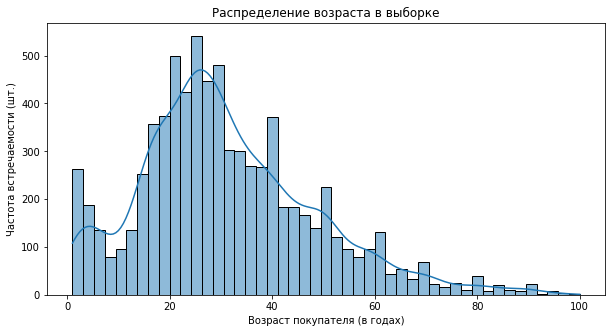

In [8]:
# строим гистограмму распределения возраста в выборке
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(labels,
             bins='auto',
             x='real_age',
             kde=True)
plt.ylabel('Частота встречаемости (шт.)')
plt.xlabel('Возраст покупателя (в годах)')
plt.title('Распределение возраста в выборке');

In [9]:
# получаем случайную подвыборку из 15 изображений
image_subsample = labels.file_name.sample(15, random_state=RANDOM_STATE)

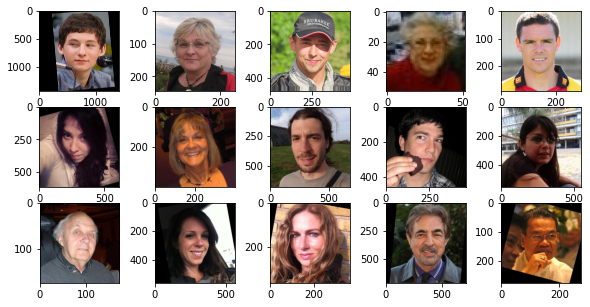

In [10]:
# выводим 15 случайных изображений
fig, axs = plt.subplots(3, 5, figsize=(10, 5))
axs = axs.flatten()
for img, ax in zip(image_subsample, axs):
    image = Image.open('/datasets/faces/final_files/' + img)
    ax.imshow(image)
plt.show()

**Вывод**

Можно видеть, что больше всего в выборке представлены фотографии людей в возрасте от 20 до 30 лет, при этом полный диапазон возрастов находится в промежутке от 1 года до 100 лет, что, безусловно, будет влиять на качество обучения модели, снижая точность её предсказаний.

Мы также видим, что фотографии в датасете разного размера, что также будет отрицательно сказываться на качестве обучения модели, поскольку у разных фотографий будет разное количество пикселей, несущих значимую информацию.

Также фотографии сами по себе очень разные по стилям и прочим характеристикам, как-то: освещённость, ориентация изображения в пространстве и т.п.

## Задача регрессии. Обучение с учителем нейронной сети ResNet50

В данном разделе мы решим задачу регрессии и выполним обучение с учителем нейронной сети `ResNet50` для предсказания возраста покупателей.

Успешно обученная нейронная сеть должна показать значение метрики MAE на тестовой выборке не больше 8.0.

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке:

```python
# загружаем тренировочную выборку
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_gen_flow


# загружаем тестовую выборку
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_gen_flow


# инициализируем модель
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    
    return model


# обучаем модель
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
2024-07-18 13:31:22.946784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-18 13:31:23.282606: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 60s - loss: 254.4548 - mae: 11.3428 - val_loss: 1076.6956 - val_mae: 28.2271
Epoch 2/5
178/178 - 43s - loss: 75.5045 - mae: 6.5222 - val_loss: 563.1516 - val_mae: 18.3654
Epoch 3/5
178/178 - 43s - loss: 49.0488 - mae: 5.3217 - val_loss: 248.3224 - val_mae: 11.7021
Epoch 4/5
178/178 - 43s - loss: 36.1695 - mae: 4.5894 - val_loss: 116.6265 - val_mae: 8.1472
Epoch 5/5
178/178 - 43s - loss: 26.5834 - mae: 3.9352 - val_loss: 78.8996 - val_mae: 6.7606
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 78.8996 - mae: 6.7606
Test MAE: 6.7606
```

## Выводы по результатам обучения модели

В исследовании были изучены 7591 снимок людей и решена задача регрессии путём обучения с учителем нейронной сети `ResNet50` для предсказания приблизительного возраста покупателей магазина.

Размеры всех изображений были приведены в диапазон от 0 до 1. Тренировочная и валидационная выборки были сформированы из полного датасета в соотношении 1:3.

В тренировочном датасете была также применена аугментация, а именно отражение снимков по горизонтали (`horizontal_flip`) для улучшения качества обучения модели.

Каждая эпоха обучения была разделена на бэтчи по 32 снимка.

Оптимизация модели проводилась алгоритмом `Adam` со значенчем `lr` = 0.0001 и функцией потерь `MSE` для ускорения процесса обучения модели.

Обучение модели было проведено на 5 эпохах.

По результатам обучения значение метрики MAE на тествовой выборке составило 6.8, что не превышает требуемого порога 8.0.

Таким образом, нейронная сеть `ResNet50`, обученная вышеуказанным образом, рекомендуется к использованию для предсказания возраста покупаталей.

Для улучшения точности предсказаний модели следует более тщательно отбирать фотографии для обучения модели, например, формировать датасет из фотографий примерно одинакового размера, а также качества снимков (освещённость, чёткость и т.п.). Выравнивание выборки по возрастам людей на фотографиях (уменьшение вариативности целевого признака) также может улучшить качество модели, однако делать это нужно осторожно, чтобы признаки не потеряли своей дифференцирующей силы для выполнения предсказаний.